<a href="https://colab.research.google.com/github/ulturac/RSNA-detection/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import csv
import random
!pip install pydicom
import pydicom
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.util import crop
from skimage.transform import resize
import csv

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

     |████████████████████████████████| 1.9MB 7.6MB/s 


In [ ]:
# model configurations
class Configuration:
    EPOCHS = 5
    LEARNING_RATE = 0.001
    BATCH = 32
    image_semibig = 128
    IMAGE_SIZE = 64
    image_small = 32
    CHANNLES = 32
    N_BLOCKS = 2
    NN_DEPTH = 4
    WORKERS = 4
    TRAIN_LABELS_PATH = '/content/drive/MyDrive/Pneumonia_folder/stage_2_train_labels.csv'
    TRAIN_IMAGES_PATH = '/content/drive/MyDrive/Pneumonia_folder/stage_2_train_images'
    TEST_IMAGES_PATH = '/content/drive/MyDrive/Pneumonia_folder/stage_2_test_images'
    TRAIN_IMAGES_PERCENT = .8 
    VALID_IMAGES_SIZE = 200

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

pneumonia_locations = {}
# Open and load stage_2_train_labels.csv file to read all the records and add locations to dictionary for all uniqueue files
# Fields 
    # patientid, x, y, width, height and target
count = 0
train_label = []
with open(os.path.join(Configuration.TRAIN_LABELS_PATH), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    
    for rows in reader:
        count+=1
        filename = rows[0] # get file name
        location = rows[1:5] # location as (x, y) point and width, height 
        target = rows[5] # it shows if the patient have pheumonia or not
        # if row contains pneumonia add location to dictionary
        # which contains a list of pneumonia locations per filename
        train_label.append(target)
        if target == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]
    
    print(count)

30227


In [ ]:
# minx = 100
# max_xpw = 0
# miny = 100
# max_yph = 0
# for coor in pneumonia_locations.values():
#   for this in coor:
#     #print(this)
#     xpw = this[0]+this[2]
#     yph = this[1]+this[3]
#     #print(xpw)
#     if this[0] < min:
#       min = this[0]
#     if xpw > max_xpw:
#       max_xpw = xpw
#     if this[1] < miny:
#       miny = this[1]
#     if yph >max_yph:
#       max_yph = yph

    
# print(min)
# print(max_xpw)
# print(miny)
# print(max_yph)

1048576
1048576
4096
4096
AxesSubplot(0.125,0.125;0.352273x0.755)
AxesSubplot(0.547727,0.125;0.352273x0.755)


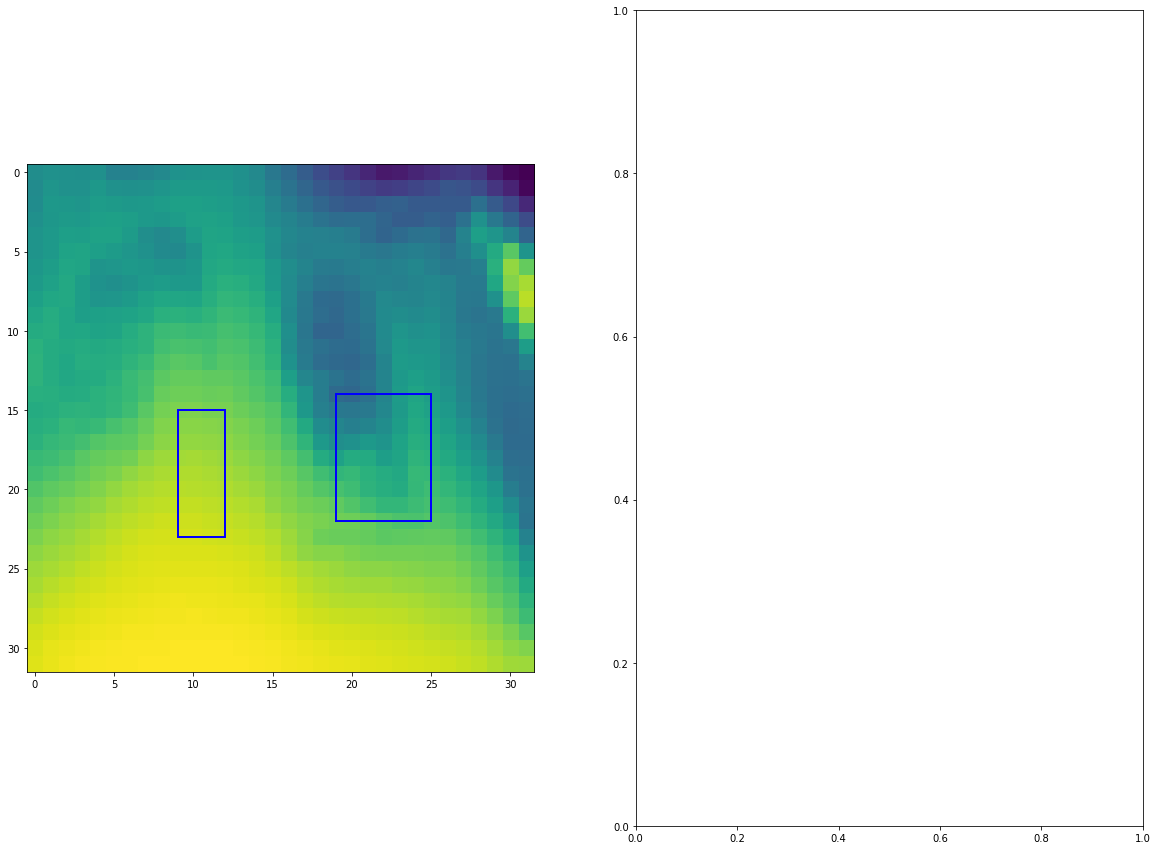

In [ ]:
file_name = '8f202a05-d9d3-43c2-aa4b-0ab8939f0607'

img = pydicom.dcmread(os.path.join(Configuration.TRAIN_IMAGES_PATH, file_name +'.dcm')).pixel_array
#print(img)
msk = np.zeros(img.shape)
#for x in img:
 # print (x)
if filename in pneumonia_locations:
    # loop through pneumonia
    for location in pneumonia_locations[filename]:
        # add 1's at the location of the pneumonia
        x, y, w, h = location
        msk[y:y+h, x:x+w] = 1
print(img.size)
print(msk.size)
img = resize(img, (Configuration.image_semibig, Configuration.image_semibig), mode='reflect')
msk = resize(msk, (Configuration.image_semibig, Configuration.image_semibig), mode='reflect') > 0.5

img = resize(img, (Configuration.IMAGE_SIZE, Configuration.IMAGE_SIZE), mode='reflect')
msk = resize(msk, (Configuration.IMAGE_SIZE, Configuration.IMAGE_SIZE), mode='reflect') > 0.5
print(img.size)
print(msk.size)
img = resize(img, (Configuration.image_small, Configuration.image_small), mode='reflect')
msk = resize(msk, (Configuration.image_small, Configuration.image_small), mode='reflect') > 0.5
img = np.expand_dims(img, -1) 
msk = np.expand_dims(msk, -1) 
#cropped = crop(img,((0,10),(0,10),(0,0)), copy=False)
axidx = 0
axidx2 = 1
#f2, axarr2 = plt.subplots(1, 2, figsize=(20,15))
#axarr2 = axarr2.ravel()
#axarr2[axidx2].imshow(cropped[:, :, ])
#print(axarr2[axidx2])
f, axarr = plt.subplots(1, 2, figsize=(20,15))
axarr = axarr.ravel()
# left image
axarr[axidx].imshow(img[:, :, 0])
#axarr[axidx2].imshow(cropped[:, :,0])
print(axarr[axidx])
print(axarr[axidx2])
# threshold true mask
comp = msk[:, :, 0] > 0.5
# apply connected components
comp = measure.label(comp)
# apply bounding boxes
predictionString = ''
# blue box showing penumonia
for region in measure.regionprops(comp):
    # retrieve x, y, height and width
    y, x, y2, x2 = region.bbox
    height = y2 - y
    width = x2 - x
    axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
axidx += 1

In [ ]:
folder = Configuration.TRAIN_IMAGES_PATH
image_dcm = os.listdir(folder)
img_list_name = []
for im in image_dcm:
 a =  im.split('.')
 img_list_name.append(a[0])
print(img_list_name)
# random.shuffle(filenames)
# print(len(filenames))
# # split into train and validation image filenames
# train_images_length = round(.8*count)
# #print(train_images_length)

# train_filenames = filenames[:train_images_length]
#print(train_filenames[5])

#train_filenames = filenames[:Configuration.TRAIN_IMAGES_PERCENT*count]
#valid_filenames = filenames[train_images_length:]
pixel_images = []
images_labels = []
count = 0
with open(os.path.join(Configuration.TRAIN_LABELS_PATH), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for y in img_list_name:
      #print("y",y)
      for rows in reader:
          
          filename = rows[0] # get file name
          print(filename)
          location = rows[1:5] # location as (x, y) point and width, height 
          target = int(rows[5]) # it shows if the patient have pheumonia or not
          # if row contains pneumonia add location to dictionary
          # which contains a list of pneumonia locations per filename
          #target = np.asarray(target)
          
          #print("name",filename)
          if y == filename:
            count+=1
            images_labels.append([target])
            print(filename)
            print(y)
            img = pydicom.dcmread(os.path.join(Configuration.TRAIN_IMAGES_PATH, y +'.dcm')).pixel_array
            print("step 1",img.size)
            #img = resize(img, (Configuration.image_semibig, Configuration.image_semibig), mode='reflect')
            print("step 2",img.size)
            #img = resize(img, (Configuration.IMAGE_SIZE, Configuration.IMAGE_SIZE), mode='reflect')
            print("step 3",img.size)
            img = resize(img, (Configuration.image_small, Configuration.image_small), mode='reflect')
            print("step 4",img.size)
            img = np.asarray(img)
            pixel_images.append([img])
            #print(filename)
            if target == 1:
              print("made it")
              #msk = np.zeros(img.shape)
              #msk = resize(msk, (Configuration.image_semibig, Configuration.image_semibig), mode='reflect') > 0.5
              #msk = resize(msk, (Configuration.IMAGE_SIZE, Configuration.IMAGE_SIZE), mode='reflect') > 0.5
              msk = resize(msk, (Configuration.image_small, Configuration.image_small), mode='reflect') > 0.5
              msk = np.asarray(msk)
              msk_images.append(msk)
              print(target)
#images_labels = np.asarray(images_labels)
#images_labels.reshape({1,32,32})
#pixel_images = np.asarray(pixel_images)
#print(pixel_images.size)
#print(images_labels.size)
print(pixel_images)
print(images_labels)
print(count)
  #for x in img:
  # print (x)
  #if filename in train_filenames:
      # loop through pneumonia
    # for location in pneumonia_locations[filename]:
    #     # add 1's at the location of the pneumonia
    #     x, y, w, h = location
    #     msk[y:y+h, x:x+w] = 1
  

#valid_filenames.append('aaaa05fe-ca12-4e73-9287-f680a0c69be2.dcm')
#for x in valid_filenames:
 # for y in train_filenames:
  #  if x == y:
   #   print(x)
    #  print(y)

Streaming output truncated to the last 5000 lines.
e25ce67d-3ab0-44d1-9e36-3b2136857b0c
e25d1f2f-99e6-4713-bf6d-59862f906444
e260b5f7-5cce-41bd-a63b-baef4cdfd3bb
e260b5f7-5cce-41bd-a63b-baef4cdfd3bb
e260d35d-f044-497e-b092-76ba75729876
e2627c52-59e7-481a-aaf2-d82c910d20c1
e2656f99-d292-4572-9f2c-2f4e7da76265
e26c3236-5c80-454d-a3fa-6d5c752b29d6
e26cf6fb-62dd-4079-88c5-9ef5af285e8e
e2727e2b-b542-4181-baca-ff3b2b885650
e275574b-e788-4b08-96ef-2f26a66cca89
e2794b5b-b146-4bb8-800a-49a5c40b23ae
e27a1adc-88a6-488b-bc9c-8ecdccf093d9
e27b401c-8464-4536-837d-2abe2438ed39
e27c61ea-5502-4033-8c74-a700de56eea4
e27d9773-4a74-4df6-a650-1c3deba22126
e2805622-6164-4945-bd30-f9b472f4019b
e2857880-a864-4391-a187-77e940705823
e28962c9-ed75-4078-bf6e-72a6f98eb4e4
e28c6af8-8862-4567-b401-cfffe1bfa623
e28db7bd-964c-4be0-a724-4a8a641d440b
e28e464d-f19f-40d9-abdb-169cfddbb36b
e28ed2f3-6562-4464-aa3a-5958339ea040
e291d547-db57-48d5-a994-4e216cddc1f2
e294484c-a1f2-4011-a62c-69b303b0895f
e29650a1-1195-40c9-ad6c-

In [ ]:

model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(28,28)), 
                                    tf.keras.layers.Dense(128, activation='relu'), 
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])


model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.fit(pixel_images, images_labels, epochs=5)

ValueError: ignored